# Importing libraries

In [258]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

In [259]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

# Polynomial function generation

In [260]:
superscript_digits = list('⁰¹²³⁴⁵⁶⁷⁸⁹')


def num_superscript(num):
  return ''.join(
      superscript_digits[int(digit)]
      for digit in str(num)
  )


def polynomial_function(degree: int, coefficients: list = None):
  if coefficients is None:
    coefficients = ([1] * degree) + [0]

  assert len(coefficients) == degree + 1, \
      "Number of coefficients should be equal to degree + 1"

  coefficients.reverse()

  power_coeff_pairs = list(enumerate(coefficients))
  power_coeff_pairs.reverse()

  polynomial_str = ' + '.join(f'{coeff}𝑥{num_superscript(power)}' for
                              power, coeff in power_coeff_pairs)

  print(f'Polynomial {degree=}: {polynomial_str}')

  def polynomial(X):
    return sum(coeff * X ** power for
               power, coeff in power_coeff_pairs)

  return polynomial

In [261]:
X = np.array([5])
polynomial_function(0)(X)
polynomial_function(1)(X)
polynomial_function(2)(X)
polynomial_function(3)(X)

Polynomial degree=0: 0𝑥⁰


array([0])

Polynomial degree=1: 1𝑥¹ + 0𝑥⁰


array([5])

Polynomial degree=2: 1𝑥² + 1𝑥¹ + 0𝑥⁰


array([30])

Polynomial degree=3: 1𝑥³ + 1𝑥² + 1𝑥¹ + 0𝑥⁰


array([155])

In [262]:
polynomial_function(0, coefficients=[13])(X)

polynomial_function(1, coefficients=[3, 0])(X)
X * 3

polynomial_function(2, coefficients=[1, 2, 5])(X)
X**2 + 2*X + 5

polynomial_function(3, coefficients=[1, 4, 3, 10])(X)
X**3 + 4*X**2 + 3*X + 10

Polynomial degree=0: 13𝑥⁰


array([13])

Polynomial degree=1: 3𝑥¹ + 0𝑥⁰


array([15])

array([15])

Polynomial degree=2: 1𝑥² + 2𝑥¹ + 5𝑥⁰


array([40])

array([40])

Polynomial degree=3: 1𝑥³ + 4𝑥² + 3𝑥¹ + 10𝑥⁰


array([250])

array([250])

# Noised data generation

In [264]:
def plot_scatter_with_line(X, y1, y2, y1_label, y2_label, title):
  plt.scatter(X, y1, label=y1_label)
  plt.plot(X, y2, color='red', label=y2_label)
  plt.title(title)
  plt.xlabel("X values")
  plt.ylabel("y values")
  plt.legend()
  plt.show()

In [303]:
def calculate_loss(y1, y2):
  mae = mean_absolute_error(y1, y2)
  mse = mean_squared_error(y1, y2)
  print(f'Mean Absolute Error (MAE): {mae:,.2f}')
  print(f'Mean Squared Error (MSE): {mse:,.2f}')

In [318]:
def random_deviation(deviation):
  return np.random.choice([np.random.uniform(-deviation, 0), np.random.uniform(0, deviation)])


def generate_noised_data(func, X_range, deviation):
  X = np.arange(X_range[0], X_range[1]+1).astype(float)
  y_original = func(X)
  y_noised = np.array([y - y * random_deviation(deviation)
                       for y in y_original])

  calculate_loss(y_noised, y_original)
  plot_scatter_with_line(X, y_noised, y_original, 'Noised y', 'Original y',
                         "Scatter plot of Noised y against Original y")
  return X, y_noised, y_original

Polynomial degree=0: 0𝑥⁰
Mean Absolute Error (MAE): 0.00
Mean Squared Error (MSE): 0.00


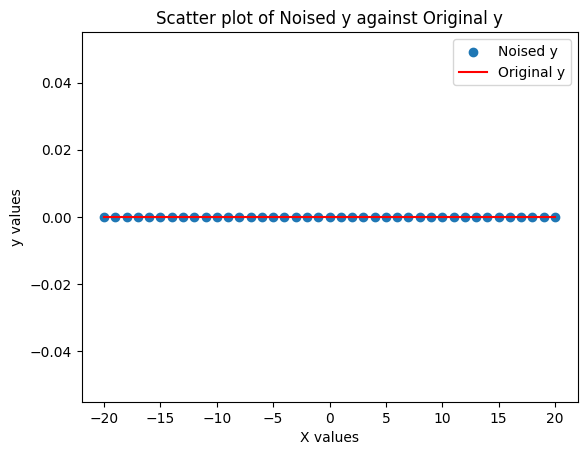

Polynomial degree=1: 1𝑥¹ + 0𝑥⁰
Mean Absolute Error (MAE): 3.05
Mean Squared Error (MSE): 14.83


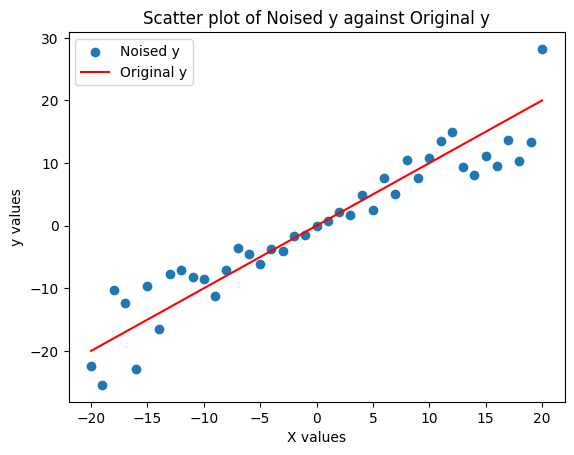

Polynomial degree=2: 1𝑥² + 1𝑥¹ + 0𝑥⁰
Mean Absolute Error (MAE): 27.18
Mean Squared Error (MSE): 2,038.74


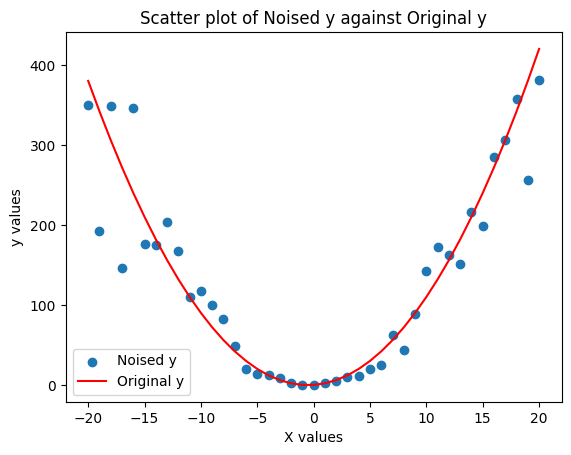

Polynomial degree=3: 1𝑥³ + 1𝑥² + 1𝑥¹ + 0𝑥⁰
Mean Absolute Error (MAE): 541.13
Mean Squared Error (MSE): 882,637.49


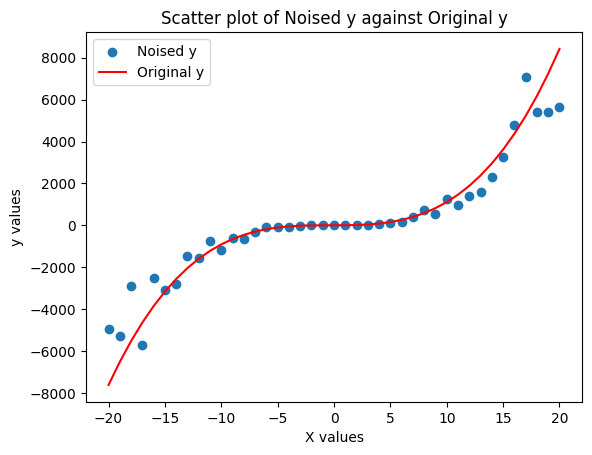

In [319]:
_ = generate_noised_data(polynomial_function(0), (-20, 20), 0.5)
_ = generate_noised_data(polynomial_function(1), (-20, 20), 0.5)
_ = generate_noised_data(polynomial_function(2), (-20, 20), 0.5)
_ = generate_noised_data(polynomial_function(3), (-20, 20), 0.5)

# Polynomial regression

In [271]:
def polynomial_feature_transform(X, degree):
  poly = PolynomialFeatures(degree=degree, include_bias=True)
  X_poly = poly.fit_transform(X.reshape(-1, 1))
  return X_poly

In [270]:
def build_polynomial_model(learning_rate, degree):
  model = Sequential([
      Input(shape=(degree + 1,)),
      Dense(units=1)
  ])
  model.compile(optimizer=RMSprop(learning_rate=learning_rate),
                loss=MeanSquaredError(),
                metrics=[RootMeanSquaredError()])
  return model

In [325]:
def plot_regression_results(X, y_noised, y_pred):
  calculate_loss(y_noised, y_pred)
  plot_scatter_with_line(X, y_noised, y_pred, 'Noised y', 'Predicted y',
                         "Scatter Plot of Noised y and Predicted y")

In [306]:
def plot_loss_curve(history):
  plt.figure(figsize=(10, 6))
  plt.plot(history.history['loss'], color='blue', label='Training Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training Loss Curve')
  plt.legend()
  plt.grid(True)
  plt.show()

In [307]:
def polynomial_regression(X, y, degree=1, learning_rate=0.1, epochs=50, batch_size=1):
  X_poly = polynomial_feature_transform(X, degree)

  model = build_polynomial_model(learning_rate=learning_rate, degree=degree)
  history = model.fit(X_poly, y, epochs=epochs, batch_size=len(y)*batch_size)
  y_pred = model.predict(X_poly)

  plot_loss_curve(history)
  plot_regression_results(X, y, y_pred)

Polynomial degree=1: 3𝑥¹ + 10𝑥⁰
Mean Absolute Error (MAE): 20.55
Mean Squared Error (MSE): 735.95


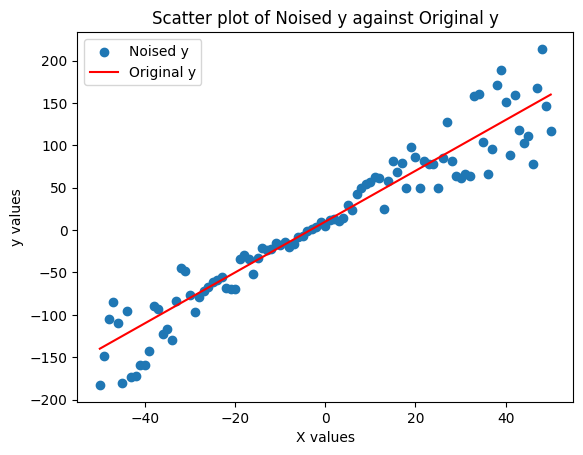

In [326]:
X, y_noised, y_original = generate_noised_data(polynomial_function(1, [3, 10]),
                                               [-50, 50], 0.5)

Epoch 1/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 8166.6025 - root_mean_squared_error: 90.3693
Epoch 2/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 8008.0376 - root_mean_squared_error: 89.4876
Epoch 3/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7894.6528 - root_mean_squared_error: 88.8519
Epoch 4/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 7800.6880 - root_mean_squared_error: 88.3215
Epoch 5/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 7717.9863 - root_mean_squared_error: 87.8521
Epoch 6/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7642.7710 - root_mean_squared_error: 87.4229
Epoch 7/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 7572.9360 - root_mean_squared_error: 87.0226
Epoch 8/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 7507.1763 - root_mean_squared_error: 86.6440
Epoch 9/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7444.6167 - root_mean_squared_error: 86.2822
Epoch 10/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 7384.6416 - r

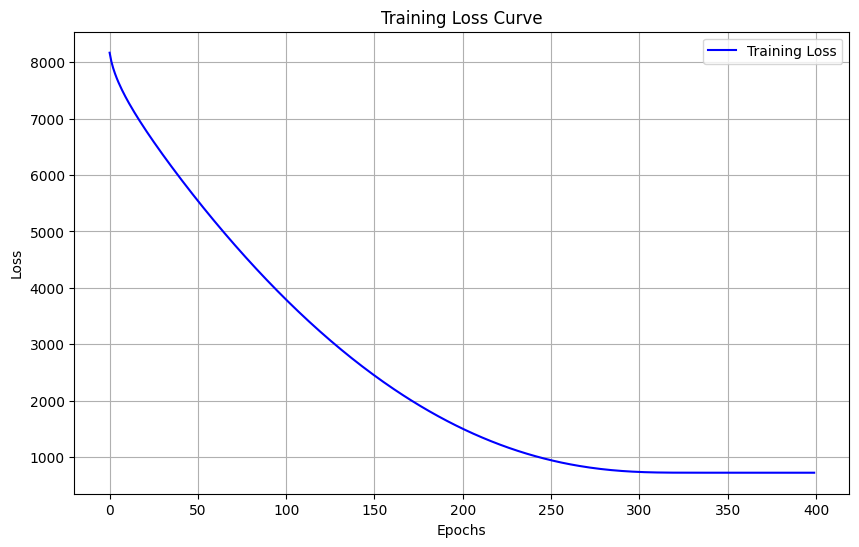

Mean Absolute Error (MAE): 20.88
Mean Squared Error (MSE): 725.69


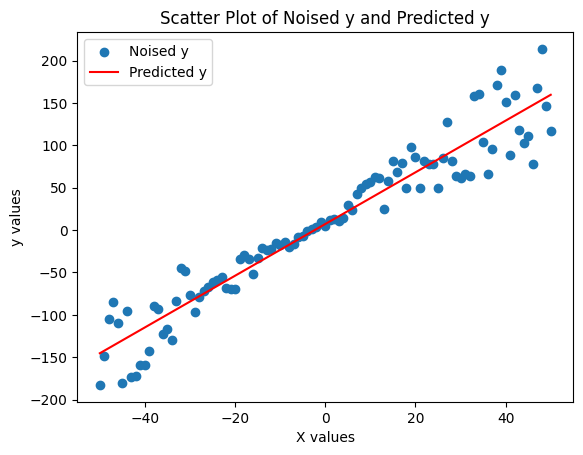

In [327]:
polynomial_regression(X, y_noised, learning_rate=0.01, epochs=400)

In [16]:
def build_model(lr):
  model = Sequential([
      Input(shape=(1,)),
      Dense(units=1)
  ])
  model.compile(optimizer=RMSprop(learning_rate=lr),
                loss="mean_squared_error", metrics=[RootMeanSquaredError()])
  return model

In [17]:
def train_model(model, X, y, epochs, batch_size):
  history = model.fit(x=X, y=y, epochs=epochs,
                      batch_size=batch_size)

  trained_weight = model.get_weights()[0][0]
  trained_bias = model.get_weights()[1]
  epochs = history.epoch
  rmse = pd.DataFrame(history.history)['root_mean_squared_error']

  return trained_weight, trained_bias, epochs, rmse

In [18]:
def plot_the_model(trained_weight, trained_bias, X, y_noised):
  plt.scatter(X, y_noised)

  # x0 = 0
  # y0 = trained_bias
  # x1 = X[-1]
  # y1 = trained_bias + (trained_weight * x1)

  # plt.plot([x0, x1], [y0, y1], 'g')
  plt.plot(X, trained_bias + (trained_weight * X), 'g')
  # plt.plot(X, y_original, 'r')
  plt.show()

In [19]:
def plot_the_loss_curve(epochs, rmse):
  plt.plot(epochs, rmse, label="Loss")

  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.legend()
  plt.show()

Epoch 1/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 714.3226 - root_mean_squared_error: 26.7268
Epoch 2/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 13915544.0000 - root_mean_squared_error: 3730.3545
Epoch 3/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 710.6994 - root_mean_squared_error: 26.6589
Epoch 4/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 107.9517 - root_mean_squared_error: 10.3900
Epoch 5/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 105.7301 - root_mean_squared_error: 10.2825
Epoch 6/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 105.6996 - root_mean_squared_error: 10.2810
Epoch 7/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 105.6986 - root_mean_squared_error: 10.2810
Epoch 8/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 105.6985 - root_mean_squared_error: 10.2810
Epoch 9/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 105.6985 - root_mean_squared_error: 10.2810
Epoch 10/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 105.6985 - root_mean_squa

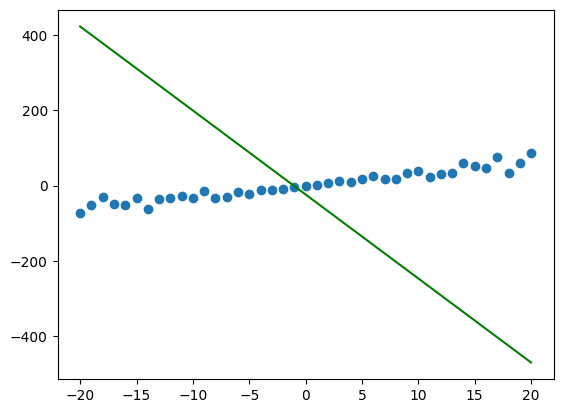

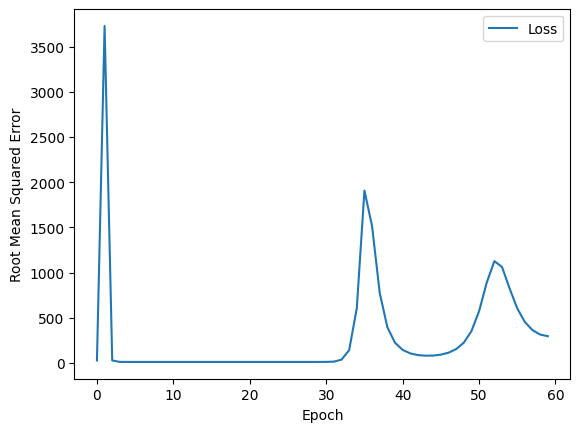

7.5792213755873945

715.9681536976884

In [20]:
from sklearn.metrics import mean_absolute_error

lr = 100.
epochs = 60
batch_size = len(y_noised)

model = build_model(lr)
trained_weight, trained_bias, epochs, rmse = train_model(
    model, X, y_noised, epochs, batch_size)
plot_the_model(trained_weight, trained_bias, X, y_noised)
plot_the_loss_curve(epochs, rmse)

mean_absolute_error(y_original, y_noised)
mean_absolute_error(y_original, (y_original * trained_weight) + trained_bias)